1 - Uso avançado de redes neurais recorrentes 

Neste exemplo, analisaremos três técnicas avançadas para melhorar o desempenho e o poder de generalização de redes neurais 
recorrentes. Ao final do exemplo, você saberá mais sobre o que há para saber sobre o uso de redes recorrentes com o Keras. 
Vamos demonstrar todos os três conceitos sobre um problema de previsão de temperatura, onde você tem acesso a uma série de 
pontos de dados provenientes de sensores instalados no telhado de um edifício, como temperatura, pressão do ar e umidade, 
que você usa para prever qual a temperatura será 24 horas após o último ponto de dados. Este é um problema bastante 
desafiador que exemplifica muitas dificuldades comuns encontradas quando se trabalha com timeseries.
Nós vamos cobrir as seguintes técnicas:
    
recorrente dropout - Esta é uma maneira específica e interna de usar o dropout para combater o overfitting em camadas recorrentes.

Empilhamento de camadas recorrentes - Isso aumenta o poder de representação da rede (ao custo de maiores cargas computacionais).

Camadas Recorrentes Bidirecionais - Apresentam as mesmas informações para uma rede recorrente de diferentes maneiras, aumentando aprecisão.

1.1 Um problema de previsão de temperatura

Dados de sequência são encontrados em muitos outros problemas do que apenas processamento de linguagem (NLP).
Neste exemplo, temos com um conjunto de dados de timeseries meteorológicos registrado na Estação meteorológica do Instituto
Max Planck para Biogeoquímica em Jena, Alemanha (www.bgc-jena.mpg.de/wetter).
Neste conjunto de dados, 14 quantidades diferentes (tais temperatura do ar, pressão atmosférica, umidade, direção do vento,
e assim por diante) foram registradas a cada 10 minutos, ao longo de vários anos. Os dados originais remontam a 2003, mas
este exemplo está limitado aos dados de 2009–2016. Este conjunto de dados é perfeito para aprender a trabalhar com timeseries
numéricos. Você vai usá-lo para construir um modelo que tome como entrada alguns dados do passado recente (alguns dias de
pontos de dados) e prevê a temperatura do ar 24 horas no futuro. 
Faça o download e descompacte os dados: https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip

In [1]:
# Inspecting the data of the Jena weather dataset

f = open('jena_climate_2009_2016.csv')
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print(header)
print(len(lines))

#Isso gera uma contagem de 420.551 linhas de dados (cada linha é um timestep: um registro de uma data e 14 valores 
#relacionados ao clima), bem como o seguinte cabeçalho:


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [2]:
# Agora, converta todas as 420.551 linhas de dados em uma matriz Numpy.
# Parsing the data
import numpy as np
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

#  Plotting the temperature timeseries
from matplotlib import pyplot as plt

temp = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)
plt.show()

<Figure size 640x480 with 1 Axes>

Aqui está o gráfico da temperatura (em graus Celsius) ao longo do tempo. Nesta gráfico, você pode ver 
claramente a periodicidade anual da temperatura.
![image.png](attachment:image.png)


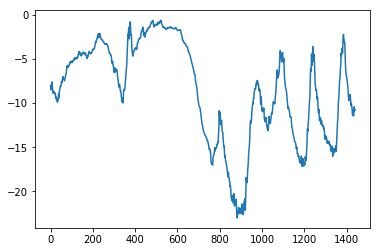

In [3]:
#  Plotting the first 10 days of the temperature timeseries
plt.plot(range(1440), temp[:1440])
plt.show()

Aqui está um gráfico mais estreito dos primeiros 10 dias de dados de temperatura. Como os dados são registrados a cada 
10 minutos, você obtém 144 pontos de dados por dia.
![image.png](attachment:image.png)

Neste gráfico, você pode ver a periodicidade diária, especialmente evidente nos últimos 4 dias. Observe também que 
esse período de 10 dias deve ser proveniente de um mês de inverno bastante frio.
Se você estivesse tentando prever a temperatura média no mês seguinte, dados alguns meses de dados anteriores, 
o problema seria fácil, devido à periodicidade confiável dos dados em escala anual. Mas olhando para os dados em uma 
escala de dias, a temperatura parece muito mais caótica. 
É esta timeseries previsível em uma escala diária? Vamos descobrir.

1.2 Preparando os dados

A formulação exata do problema será a seguinte: dados fornecidos indo tão longe (para trás) quanto lookback timesteps (um intervalo de 
timestep é de 10 minutos) e amostrado a cada timesteps, você pode prever a temperatura em delay timesteps? Você usará os 
seguintes valores de parâmetro:
    
lookback = 720 - as observações retornarão 5 dias.

step = 6 - As observações serão amostradas em um ponto de dados por hora.

delay = 144 - os targets serão 24 horas no futuro.

Para começar, você precisa fazer duas coisas:
- Pré-processe os dados para um formato que uma rede neural possa ingerir. Isso é fácil: os dados já são numéricos, 
então você não precisa fazer nenhuma vetorização. Mas cada timeseries nos dados está em uma escala diferente 
(por exemplo, a temperatura é tipicamente entre -20 e +30, mas a pressão atmosférica, medida em mbar, é em torno de 1.000). 
Você normalizará cada série de tempo de maneira independente, para que todas elas tenham valores pequenos em uma escala semelhante.

- Escreva um gerador Python que use a matriz atual de dados e forneça lotes (batches) de dados do passado recente, junto com 
uma temperatura-alvo no futuro. Como as amostras no conjunto de dados são altamente redundantes (o exemplo N e
o exemplo N + 1 terá a maioria dos seus timesteps em comum), seria um desperdício atribuir explicitamente cada amostra. 
Em vez disso, você gerará as amostras rapidamente usando os dados originais.

Pré-processar os dados subtraindo a média de cada timeseries e dividindo pelo desvio padrão. Usar os primeiros 
200.000 timesteps como dados de treinamento, portanto calcule a média e o desvio padrão apenas nessa fração dos dados.



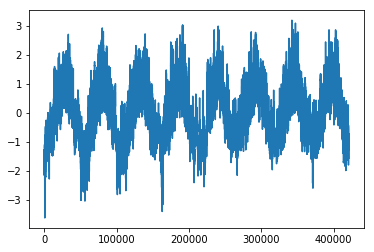

In [5]:
# Normalizing the data
mean = float_data[:200_000].mean(axis=0)
float_data -= mean
std = float_data[:200_000].std(axis=0)
float_data /= std # desvio padrão

temp1 = float_data[:, 1]  # temperature (in degrees Celsius)
plt.plot(range(len(temp1)), temp1)
plt.show()

O gerador de dados que você usará produz uma tupla (exemplos, rótulos), onde os exemplos são 
um batch (lote) de dados de entrada e os rótulos são a matriz correspondente de temperaturas alvo. Leva os seguintes argumentos:

    data - A matriz original de dados de ponto flutuante, que você normalizou.
    lookback — Quantos timesteps de retorno os dados de entrada devem ser enviados.
    delay - Quantos timesteps no futuro o alvo deve ser.
    min_index e max_index - índices na matriz de dados que delimitam quais timesteps serão extraídos. 
    Isso é útil para manter um segmento dos dados para validação e outro para testes.
    shuffle - para embaralhar as amostras ou desenhá-las em ordem cronológica.
    batch_size - o número de amostras por lote.
    step - O período, em tempo, no qual você amostra dados. Você definirá como 6 para desenhar um ponto de dados a 
    cada hora.

In [6]:
# Generator yielding timeseries samples and their targets
def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        yield samples, targets

Agora, vamos usar a função de gerador abstrata para instanciar três geradores: um para treinamento, um para validação 
e um para teste. Cada um olhará para diferentes segmentos dos dados originais: o gerador de treinamento examina os 
primeiros 200.000 timesteps, o gerador de validação examina os 100.000 seguintes e o gerador de teste examina o restante.

In [9]:
# Preparing the training, validation, and test generators
lookback = 1440
step = 6
delay = 144
batch_size = 128
train_gen = generator(float_data,
                      lookback=lookback,
                      delay=delay,
                      min_index=0,
                      max_index=200000,
                      shuffle=True,
                      step=step,
                      batch_size=batch_size)
val_gen = generator(float_data,
                    lookback=lookback,
                    delay=delay,
                    min_index=200_001,
                    max_index=300_000,
                    step=step,
                    batch_size=batch_size)
test_gen = generator(float_data,
                     lookback=lookback,
                     delay=delay,
                     min_index=300001,
                     max_index=None,
                     step=step,
                     batch_size=batch_size)

# Quantos passos para desenhar a partir de val_gen, a fim de ver o conjunto inteiro de validação
val_steps = (300000 - 200001 - lookback)
# Quantos passos para desenhar a partir de test_gen, a fim de ver todo o conjunto de testes
test_steps = (len(float_data) - 300001 - lookback)


1.3 Uma linha de base de bom senso e sem aprendizado de máquina

Antes de começar a usar os modelos de aprendizagem profunda de caixa preta para resolver o problema da previsão de 
temperatura, vamos tentar uma abordagem simples e de senso comum. Ele servirá como uma verificação de integridade e 
estabelecerá uma linha de base que você terá que superar para demonstrar a utilidade dos modelos de aprendizado de máquina 
mais avançados. Tais linhas de base de senso comum pode ser útil quando você está abordando um novo problema para o qual 
não há solução conhecida (ainda). Um exemplo clássico é o das tarefas de classificação desequilibradas, em que algumas 
classes são muito mais comuns do que outras. Se seu conjunto de dados contiver 90% de exemplos de classe A e 10% de exemplos
de classe B, então uma abordagem de senso comum para a tarefa de classificação é sempre prever “A” quando apresentada com 
uma nova amostra. Tal classificador é 90% preciso no geral, e qualquer abordagem baseada em aprendizado deve, portanto, 
superar essa pontuação de 90% para demonstrar utilidade. Às vezes, essas linhas de base elementares podem ser 
surpreendentemente difíceis de serem superadas.

Neste caso, a série de tempos de temperatura pode ser seguramente assumida como contínua (as temperaturas de amanhã 
provavelmente estarão próximas das temperaturas de hoje), bem como periódicas com um período diário. Assim, uma abordagem 
de senso comum é sempre prever que a temperatura daqui a 24 horas será igual à temperatura no momento. 
Vamos avaliar essa abordagem usando a métrica do erro absoluto médio (MAE):

In [10]:
# Computing the common-sense baseline MAE
def evaluate_naive_method():
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds, targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

evaluate_naive_method()

# Converting the MAE back to a Celsius error
celsius_mae = 0.29 * std[1]

KeyboardInterrupt: 

Isso produz um MAE de 0,29. Como os dados de temperatura foram normalizados para serem centralizados em 0 e 
têm um desvio padrão de 1, esse número não é imediatamente interpretável. 
Ele se traduz em um erro absoluto médio de 0,29 × temperatura_std graus Celsius: 2,57˚C.

Esse é um erro absoluto médio razoavelmente grande. 
Agora o jogo é usar seu conhecimento de aprendizagem profunda para fazer melhor.

1.4 Uma abordagem básica de aprendizado de máquina

Da mesma forma que é útil estabelecer uma linha de base de senso comum antes de tentar abordagens de aprendizado de 
máquina, é útil tentar modelos simples e baratos de aprendizado de máquina (como redes pequenas e densamente conectadas) 
antes de examinar modelos complicados e computacionalmente caros como RNNs. Esta é a melhor 
maneira de garantir que mais complexidade é legítimo e entrega benefícios reais.

O código a seguir mostra um modelo totalmente conectado que inicia com o achatamento (flatten) dos dados e, em seguida, 
o executa por meio de duas camadas Densas. Observe a falta de função de ativação na última camada Densa, 
que é típica de um problema de regressão. Você usa o MAE como a perda. Como você avalia exatamente os mesmos dados 
e com a mesma métrica que fez com a abordagem de senso comum, os resultados serão diretamente comparáveis.

In [ ]:
# Training and evaluating a densely connected model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# Plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

![image.png](attachment:image.png)
Algumas das perdas de validação estão próximas da linha de base de não-aprendizado, mas não de forma confiável. Isso 
mostra o mérito de ter essa linha de base em primeiro lugar: não é fácil superá-la. Seu senso comum contém muitas 
informações valiosas a que um modelo de aprendizado de máquina não tem acesso.

Você pode se perguntar: se existe um modelo simples e de bom desempenho para ir dos dados até os alvos 
(a linha de base de bom senso), por que o modelo que você está treinando o encontra e melhora? Porque esta solução 
simples não é o que sua configuração de treinamento está procurando. O espaço dos modelos em que você está procurando 
uma solução, isto é, sua espaço de hipótese - é o espaço de todas as redes de duas camadas possíveis com a configuração 
que você definiu. Essas redes já são bastante complicadas. Quando você procura uma solução com um espaço de modelos complicados, a linha 
de base simples e de bom desempenho pode ser desaprendida, mesmo que seja tecnicamente parte do espaço de hipóteses. 
Essa é uma limitação bastante significativa do aprendizado de máquina em geral: a menos que o algoritmo de aprendizado 
seja codificado para procurar um tipo específico de modelo 
simples, o aprendizado de parâmetro pode falhar em encontrar uma solução simples para um problema simples.


1.5 Uma primeira linha de base recorrente

A primeira abordagem totalmente conectada não funcionou bem, mas isso não significa que o aprendizado de máquina 
não é aplicável a esse problema. A abordagem anterior primeiro nivelou as séries de tempo, o que removeu a noção de 
tempo dos dados de entrada. Em vez disso, vamos analisar os dados como eles são: uma sequência em que a causalidade e a 
ordem importam. Você tentará um modelo de processamento de sequência recorrente - ele deve ser o ajuste perfeito para 
esses dados de sequência, precisamente porque ele explora a ordenação temporal de pontos de dados, 
diferentemente da primeira abordagem.

Você usará a camada GRU, desenvolvida por Chung et al. em 2014.5 As camadas de unidade recuada 
(GRU - Gated Recurrent Unit) funcionam usando o mesmo princípio que o LSTM, mas elas são um pouco simplificadas e, 
portanto, mais baratas de serem executadas (embora possam não ter tanto poder representacional quanto o LSTM). 
Esse trade-off entre custo computacional e poder representacional é visto em toda parte no aprendizado de máquina.


In [ ]:
# Training and evaluating a GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)
# Plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Muito melhor! Você pode superar significativamente a linha de base do senso comum, demonstrando o valor do 
aprendizado de máquina, bem como a superioridade de redes recorrentes em comparação com redes densas de achatamento 
de seqüência nesse tipo de tarefa.

![image.png](attachment:image.png)

O novo MAE de validação de ~ 0,265 (antes de começar a sobredimensionar significativamente) se traduz em um erro 
absoluto médio de 2,35˚C após a desnormalização. Isso é um ganho sólido no erro inicial de 2,57˚C, mas você provavelmente 
ainda tem uma pequena margem de melhoria.


1.6 Usando dropout recorrente para combater overfitting

É evidente a partir das curvas de treinamento e validação que o modelo está tendo overfitting: as perdas de 
treinamento e validação começam a divergir consideravelmente após algumas épocas. Uma técnica clássica para combater 
esse fenômeno: dropout, que zera aleatoriamente as unidades de entrada de 
uma camada para quebrar as correlações de ocorrência nos dados de treinamento aos quais a camada está exposta. 
Mas como aplicar corretamente o dropout em redes recorrentes não é uma questão trivial. Há muito se sabe que a 
aplicação do dropout antes de uma camada recorrente dificulta a aprendizagem, em vez de ajudar na regularização. 
Em 2015, Yarin Gal, como parte de sua tese de PhD sobre aprendizagem profunda Bayesiana ( http://mlg.eng.cam.ac.uk/
yarin/blog_2248.html), determinou a maneira correta de usar o dropout com uma rede recorrente:
a mesma máscara de eliminação (o mesmo padrão de unidades descartadas) deve ser aplicada a cada timestep, em vez de uma 
máscara de dropout que varia aleatoriamente de timestep a timestep. Além disso, a fim de regularizar as representações 
formadas pelos portais recorrentes das camadas como GRU e LSTM, uma máscara de dropout constante no tempo deve ser aplicada 
às ativações recorrentes internas da camada (uma máscara de dropout recorrente). Usar a mesma máscara de abandono a cada 
timestep permite que a rede propague adequadamente seu erro de aprendizado ao longo do tempo; uma máscara de abandono 
temporal aleatória interromperia esse sinal de erro e seria prejudicial ao processo de aprendizagem.

Yarin Gal fez sua pesquisa usando Keras e ajudou a construir esse mecanismo diretamente nas camadas recorrentes de Keras. 
Cada camada recorrente em Keras possui dois argumentos relacionados a dropout: dropout, um float especificando a taxa de 
dropout para unidades de entrada da camada e recurrent_dropout, especificando a taxa de dropout das unidades 
recorrentes. Vamos adicionar dropout e dropout recorrente à camada GRU e ver como isso afeta o overfitting. 
Como as redes que estão sendo regularizadas com o abandono sempre levam mais tempo para convergir totalmente, você 
treinará a rede para o dobro de épocas.

In [ ]:
# Training and evaluating a dropout-regularized GRU-based model
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                     dropout=0.2,
                     recurrent_dropout=0.2,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# Plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

Sucesso! Você não está mais exagerando nas primeiras 30 épocas. 
Mas, embora você tenha pontuações de avaliação mais estáveis, sua melhor pontuação não é muito menor do que anteriormente.

![image.png](attachment:image.png)

1.7 Empilhando camadas recorrentes

Como você não está mais com overfitting, mas parece ter atingido um gargalo de desempenho, considere aumentar a 
capacidade da rede. Lembre-se da descrição do fluxo de trabalho universal de aprendizado de máquina: geralmente, é 
uma boa ideia aumentar a capacidade de sua rede até que o overfitting se torne o principal obstáculo 
(supondo que você já esteja tomando as medidas básicas para atenuar o overfitting). Contanto que você não esteja super 
adaptando muito, provavelmente estará abaixo da capacidade.

Aumentar a capacidade de rede normalmente é feito aumentando o número de unidades nas camadas ou adicionando mais 
camadas. O empilhamento recorrente de camadas é uma maneira clássica de construir redes recorrentes mais poderosas: 
por exemplo, o que atualmente alimenta o algoritmo do Google Tradutor é uma pilha de sete camadas grandes de LSTM - 
isso é enorme.

Para empilhar camadas recorrentes umas em cima das outras em Keras, todas as camadas intermediárias devem retornar 
sua sequência completa de saídas (um tensor 3D) em vez de sua saída no último intervalo de tempo. 
Isso é feito especificando return_sequences = True.

In [ ]:
# Training and evaluating a dropout-regularized, stacked GRU model

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
#GRU é a "célula" de amostras passadas
model.add(layers.GRU(32,
                     dropout=0.1,
                     recurrent_dropout=0.5,
                     return_sequences=True,
                     input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(64, activation='relu',
                     dropout=0.1,
                     recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

# Plotting results
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()


Você pode ver que a camada adicionada melhora o
resulto um pouco, embora não significativamente. Você pode tirar duas conclusões:
    
- Como você ainda não está super adaptando demais, pode aumentar com segurança o tamanho de suas camadas em uma 
busca pela melhoria da perda de validação. Isso tem um custo computacional não desprezível, no entanto.

- A adição de uma camada não ajudou por um fator significativo, portanto você pode estar vendo retornos decrescentes 
da crescente capacidade da rede neste momento.

![image.png](attachment:image.png)

1.8 Usando RNNs bidirecionais

A última técnica introduzida nesta seção é chamada de RNNs bidirecionais. Um RNN bidirecional é uma variante RNN 
comum que pode oferecer um desempenho maior do que um RNN regular em determinadas tarefas. Ele é freqüentemente usado 
no processamento de linguagem natural - você pode chamar de canivete suíço de aprendizado profundo para processamento 
de linguagem natural.

Os RNNs são notavelmente dependentes da ordem ou dependentes do tempo: eles processam os timesteps de suas sequências 
de entrada em ordem, e embaralhar ou reverter os timesteps pode mudar completamente as representações que o RNN extrai 
da sequência. Esta é precisamente a razão pela qual eles executam bem em problemas onde a ordem é significativa, como o 
problema de previsão de temperatura. Um RNN bidirecional explora a sensibilidade de ordem dos RNNs: consiste em usar dois
RNNs regulares, como as camadas GRU e LSTM com as quais você já está familiarizado, cada qual processa a sequência de 
entrada em uma direção (cronológica e anticronologicamente) e fundindo suas representações. Ao processar uma sequência 
nos dois sentidos, um RNN bidirecional pode capturar padrões que podem ser ignorados por um RNN unidirecional.

Notavelmente, o fato de que as camadas RNN nesta seção processaram sequências em ordem cronológica (datas mais antigas 
primeiro) pode ter sido uma decisão arbitrária. Pelo menos, é uma decisão que não fizemos nenhuma tentativa de questionar 
até agora. Os RNNs poderiam ter funcionado bem o suficiente se processassem seqüências de entrada em ordem anticronológica,
por exemplo (newest timepeps first)? Vamos tentar isso na prática e ver o que acontece. Tudo o que você precisa fazer é 
escrever uma variante do gerador de dados onde as seqüências de entrada são revertidas ao longo da dimensão de tempo 
(substitua a última linha pelas amostras de rendimento [:, :: - 1,:], targets). Treinando a mesma rede de uma camada GRU 
que você usou no primeiro experimento desta seção, você obtém os resultados mostrados na figura a seguir.

![image.png](attachment:image.png)

A GRU de ordem reversa tem um desempenho muito baixo até mesmo na linha de base de senso comum, indicando que, 
nesse caso, o processamento cronológico é importante para o sucesso de sua abordagem. Isso faz todo o sentido: a 
camada GRU subjacente normalmente será melhor para lembrar o passado recente do que o passado distante e, 
naturalmente, os pontos de dados climáticos mais recentes são mais preditivos do que pontos de dados mais antigos 
para o problema (é o que faz a linha de base de senso comum bastante forte). Assim, a versão cronológica da camada 
é obrigada a superar a versão de ordem inversa. É importante ressaltar que isso não é verdade para muitos outros 
problemas, incluindo a linguagem natural: intuitivamente, a importância de uma palavra para entender uma frase 
geralmente não depende de sua posição na sentença. 


Agora vamos tentar outra abordagem na tarefa de previsão de temperatura

In [ ]:
# Training a bidirectional GRU
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Bidirectional(
    layers.GRU(32), input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=40,
                              validation_data=val_gen,
                              validation_steps=val_steps)

Isso funciona tão bem quanto a camada regular de GRU. É fácil entender por quê: toda a capacidade preditiva deve 
vir da metade cronológica da rede, porque a metade anticronológica é conhecida por estar gravemente abaixo do 
desempenho nessa tarefa (novamente, porque o passado recente é muito mais importante do que o passado distante neste caso). 